# VpC - Trabajo Práctico 1

Algoritmo White Patch - Implementación de diferentes versiones para corrección de color
Análisis de Histogramas - Evaluación de histogramas como característica para clasificación de imágenes

In [ ]:
# Soporte Colab

import sys
import os

# Detectar si estamos en Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Entorno Colab detectado. Configurando proyecto...")

    # Clonar repo solo si no existe
    repo_url = "https://github.com/jbrazonath/VpComp.git"
    repo_name = "VpComp"

    if not os.path.exists(repo_name):
        print(f"Clonando repo {repo_url}...")
        os.system(f"git clone {repo_url}")

    import os

    # Cambiar al directorio TP2 dentro del repo
    os.chdir("/content/VpComp/Tp1")

    # Verificar directorio actual
    print("Directorio actual:", os.getcwd())

else:
    print("No se está ejecutando en Colab. Se asume que los archivos ya están localmente.")


No se está ejecutando en Colab. Se asume que los archivos ya están localmente.


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

## 1. Algoritmo White Patch - Versión Simple

Se desarrolló una versión básica del algoritmo que ofreció resultados satisfactorios en las imágenes test_*.jpg.
El algoritmo White Patch asume que el píxel más brillante de cada canal debería ser blanco.

In [3]:
def white_patch(img: np.ndarray):
    img_float = img.astype(np.float32)
    max_channel_value = np.max(img_float, axis=(0, 1))
    cantidad_de_desviaciones = 1.5
    correction_factors = np.ones(3, dtype=np.float32)
    
    for i in range(len(max_channel_value)):
        if max_channel_value[i] < 1:
            correction_factors[i] = 255 / (np.mean(img_float[:, :, i]) - 
                                         cantidad_de_desviaciones*np.std(img_float[:, :, i]))
        elif max_channel_value[i] > 254:
            correction_factors[i] = 255 / (np.mean(img_float[:, :, i]) + 
                                         cantidad_de_desviaciones*np.std(img_float[:, :, i]))
        else:
            correction_factors[i] = 255.0 / np.clip(max_channel_value[i], 1, 254)

    corrected_img = img_float * correction_factors
    corrected_img = np.clip(corrected_img, 0, 255).astype(np.uint8)
    return corrected_img

## 2. Algoritmo White Patch Inteligente

Implementa diferentes estrategias para mejores resultados.
La versión inicial no contemplaba situaciones límite, como la presencia de píxeles con valores 0 o 255. Por ello se creó una segunda variante que sí considera estos extremos. Estas dos primeras iteraciones funcionaron bien sobre las imágenes wp_*.jpg.

In [4]:
def white_patch_intelligent(img: np.ndarray, method='percentile', percentile=99.5):
    img_float = img.astype(np.float32)

    if method == 'percentile':
        reference_values = np.percentile(img_float, percentile, axis=(0, 1))

    elif method == 'edge_based':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        kernel = np.ones((3, 3), np.uint8)
        edges_dilated = cv2.dilate(edges, kernel, iterations=1)

        reference_values = []
        for i in range(3):
            channel_values = img_float[:, :, i][edges_dilated > 0]
            if len(channel_values) > 0:
                reference_values.append(np.percentile(channel_values, 95))
            else:
                reference_values.append(np.max(img_float[:, :, i]))
        reference_values = np.array(reference_values)

    elif method == 'iterative':
        reference_values = np.zeros(3)
        for i in range(3):
            channel = img_float[:, :, i].copy()
            saturated_pixels = channel[channel > 240]

            if len(saturated_pixels) == 0:
                reference_values[i] = np.max(channel)
            else:
                for iteration in range(3):
                    valid_pixels = channel[channel < 240]
                    if len(valid_pixels) > 0:
                        threshold = np.percentile(valid_pixels, 98)
                        channel = valid_pixels[valid_pixels <= threshold]
                    else:
                        break
                reference_values[i] = np.max(channel) if len(channel) > 0 else 255

    elif method == 'robust_max':
        reference_values = []
        for i in range(3):
            channel = img_float[:, :, i]
            mean_val = np.mean(channel)
            std_val = np.std(channel)

            if std_val < 10:
                reference_values.append(np.percentile(channel, 99))
            elif std_val > 50:
                reference_values.append(mean_val + 2.0 * std_val)
            else:
                reference_values.append(mean_val + 1.5 * std_val)
        reference_values = np.array(reference_values)

    reference_values = np.clip(reference_values, 1, 254)
    correction_factors = 255.0 / reference_values
    corrected_img = img_float * correction_factors
    corrected_img = np.clip(corrected_img, 0, 255).astype(np.uint8)
    return corrected_img

## 3. Algoritmo White Patch Adaptativo

Selecciona automáticamente el mejor método según las características de la imagen.
Se construyó una variante que primero clasifica la imagen usando la media y la desviación estándar del brillo y la saturación, y luego aplica el método más conveniente según esa clase. A simple vista los resultados son correctos, aunque no afirmaría que superen a los de las versiones previas.

In [5]:
def white_patch_adaptive(img: np.ndarray):
    img_float = img.astype(np.float32)
    mean_brightness = np.mean(img_float)
    std_brightness = np.std(img_float)
    saturated_pixels = np.sum(img_float > 250) / img_float.size

    if saturated_pixels > 0.01:
        method = 'iterative'
    elif std_brightness < 20:
        method = 'percentile'
    elif mean_brightness < 80:
        method = 'robust_max'
    else:
        method = 'edge_based'

    return white_patch_intelligent(img, method=method)

## 4. Procesamiento de Imágenes

Procesamiento de todas las imágenes del directorio white_patch.

In [6]:
BASE_IMG_FOLDERS = Path("Material_TPs/TP1/white_patch")
RESULTS_FOLDER = Path("results")
RESULTS_FOLDER.mkdir(exist_ok=True)

def process_and_display_images():
    image_paths = list(BASE_IMG_FOLDERS.glob("*.png")) + list(BASE_IMG_FOLDERS.glob("*.jpg"))
    
    for img_path in image_paths:
        img = cv2.imread(str(img_path))
        if img is None:
            continue
            
        corrected_img = white_patch_adaptive(img.copy())
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        corrected_rgb = cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB)
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        axes[0].imshow(img_rgb)
        axes[0].set_title(f"Original: {img_path.name}")
        axes[0].axis('off')
        
        axes[1].imshow(corrected_rgb)
        axes[1].set_title(f"White Patch: {img_path.name}")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        result_filename = RESULTS_FOLDER / f"{img_path.stem}_comparison.png"
        plt.savefig(result_filename, dpi=300, bbox_inches='tight')

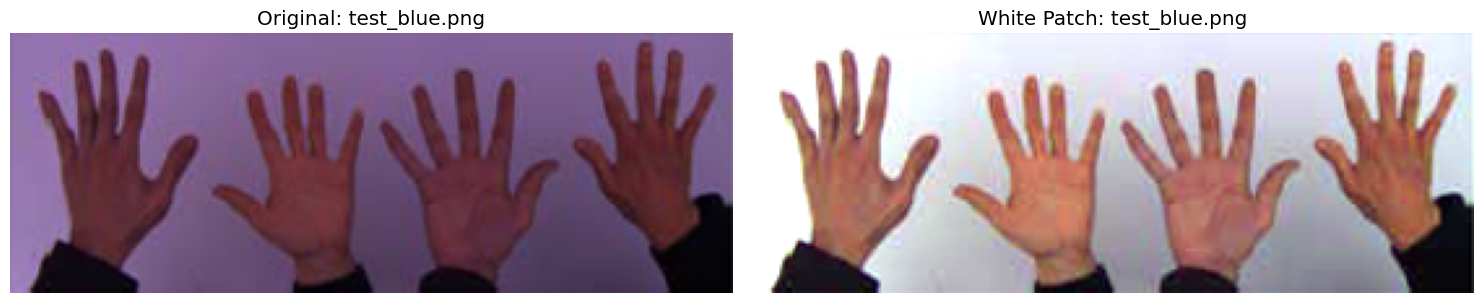

<Figure size 1200x800 with 0 Axes>

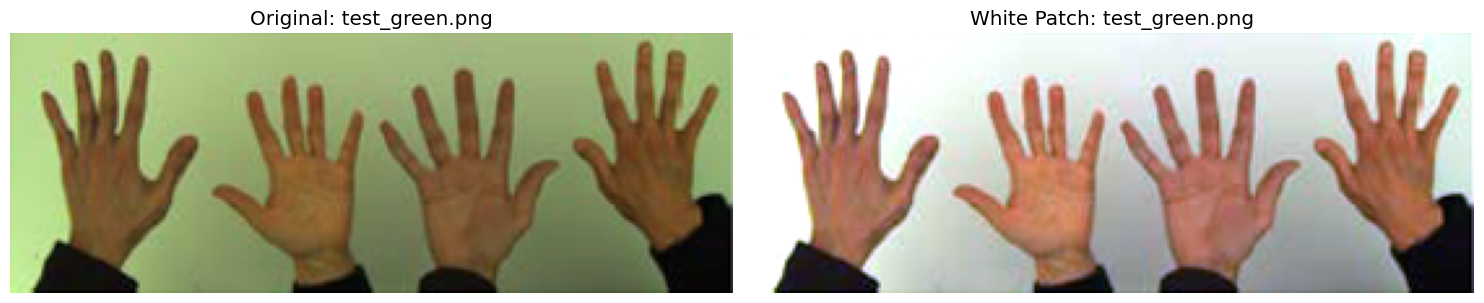

<Figure size 1200x800 with 0 Axes>

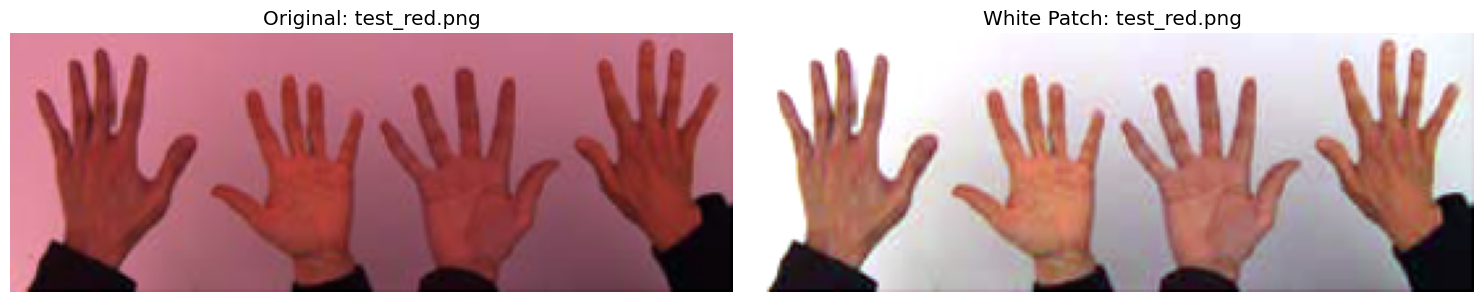

<Figure size 1200x800 with 0 Axes>

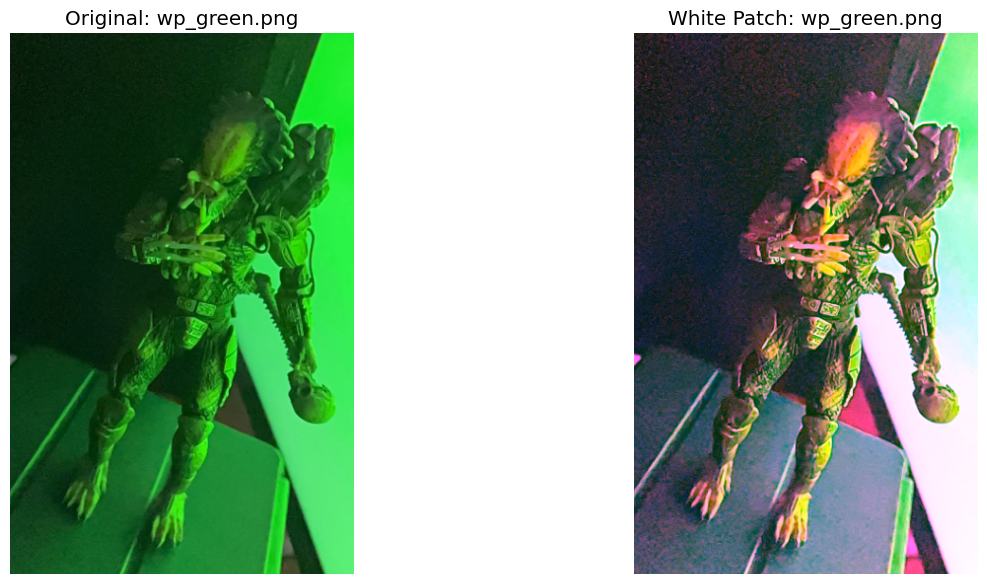

<Figure size 1200x800 with 0 Axes>

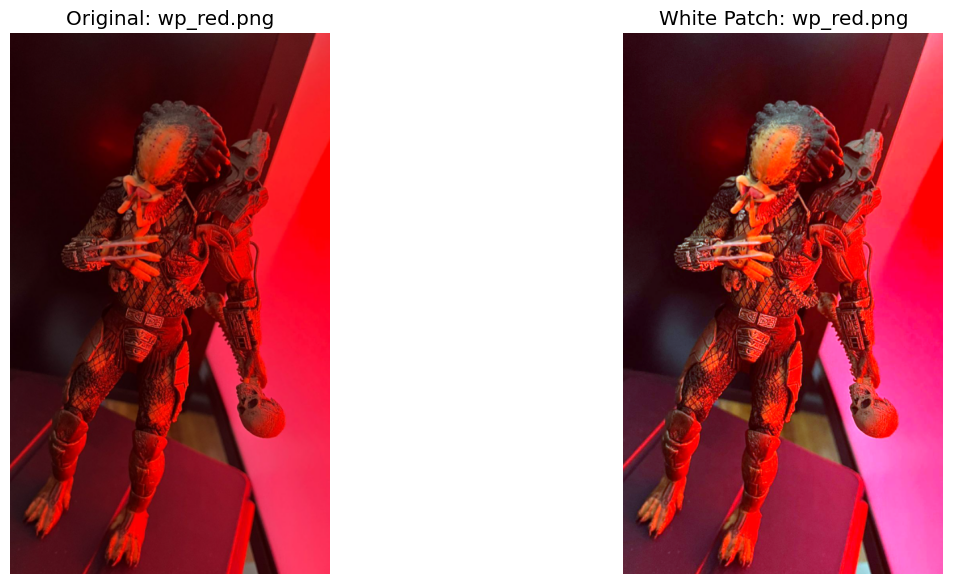

<Figure size 1200x800 with 0 Axes>

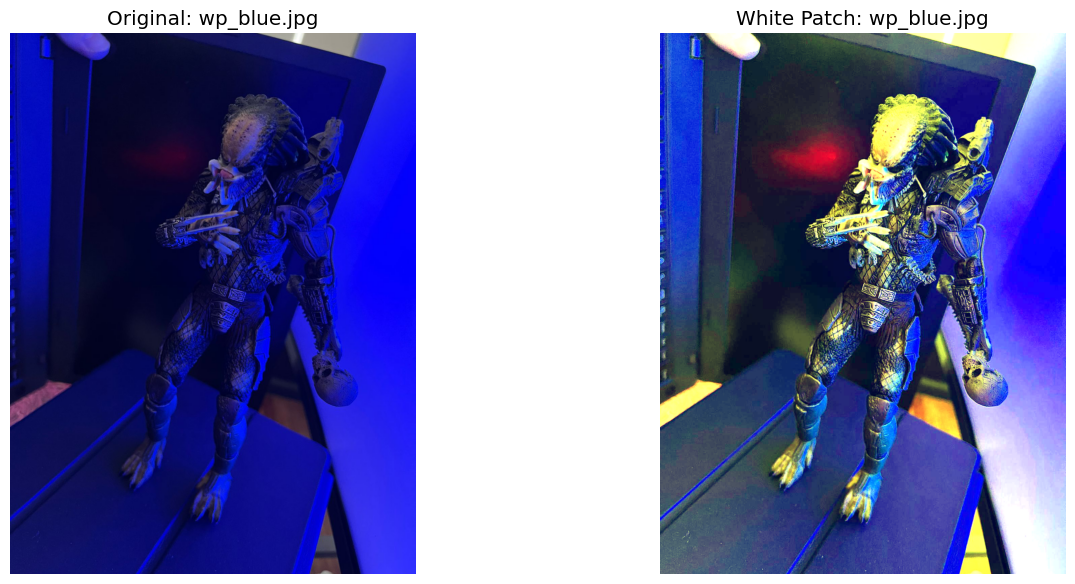

<Figure size 1200x800 with 0 Axes>

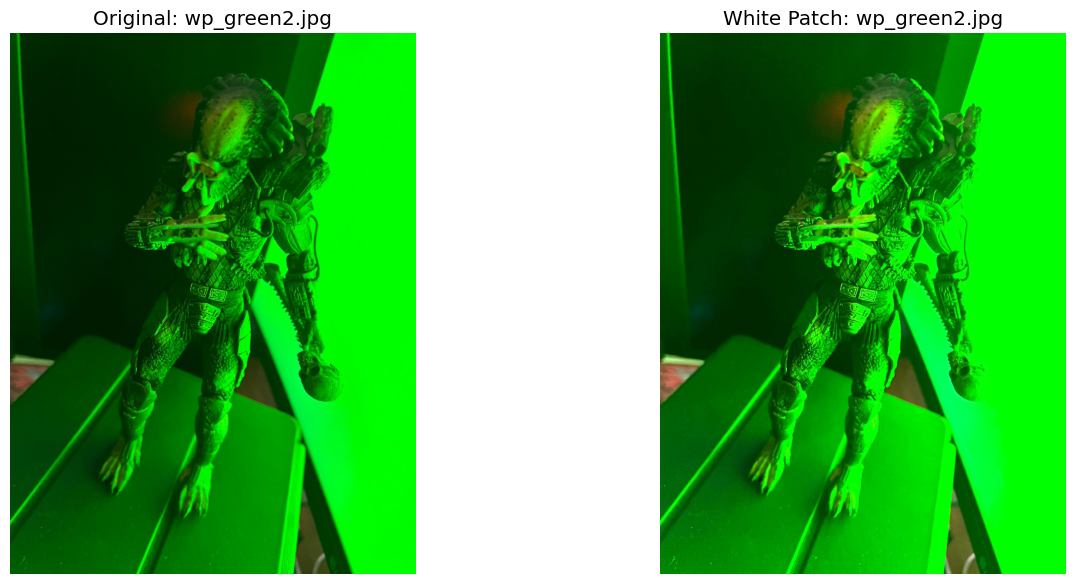

<Figure size 1200x800 with 0 Axes>

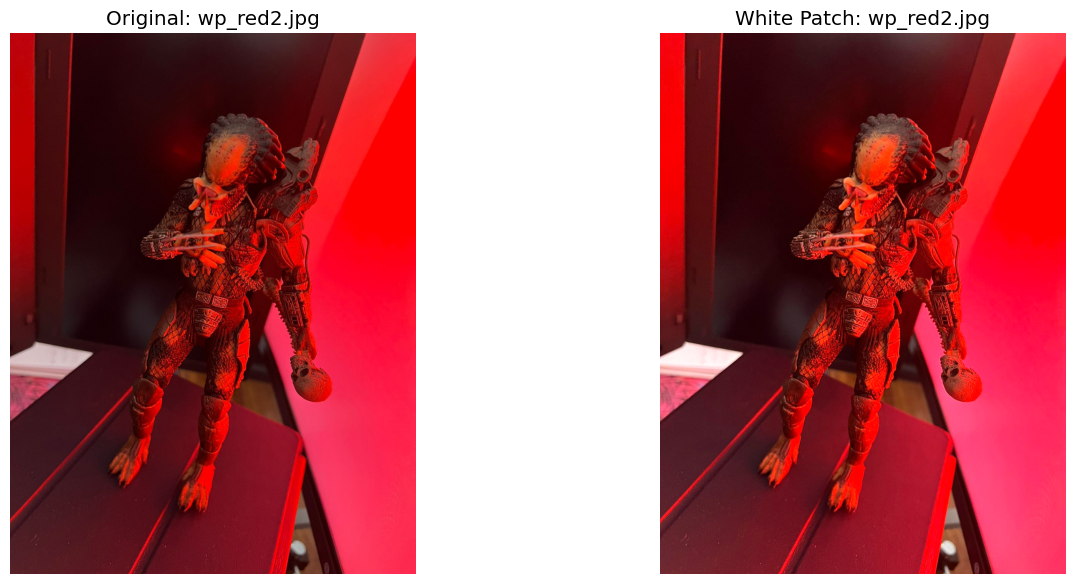

<Figure size 1200x800 with 0 Axes>

In [7]:
process_and_display_images()

## 5. Análisis de Histogramas

Análisis de histogramas como característica para clasificación de imágenes.

In [8]:
PATH_IMG_1 = "Material_TPs/TP1/img1_tp.png"
PATH_IMG_2 = "Material_TPs/TP1/img2_tp.png"

### Carga de imágenes y cálculo de histogramas

In [9]:
img_1 = cv2.imread(PATH_IMG_1, cv2.IMREAD_GRAYSCALE)
img_2 = cv2.imread(PATH_IMG_2, cv2.IMREAD_GRAYSCALE)

hist_1, bins_1 = np.histogram(img_1.ravel(), 255)
hist_2, bins_2 = np.histogram(img_2.ravel(), 255)

histograms_identical = np.array_equal(hist_1, hist_2)
print(f"Histogramas idénticos: {histograms_identical}")

Histogramas idénticos: True


### Visualización comparativa

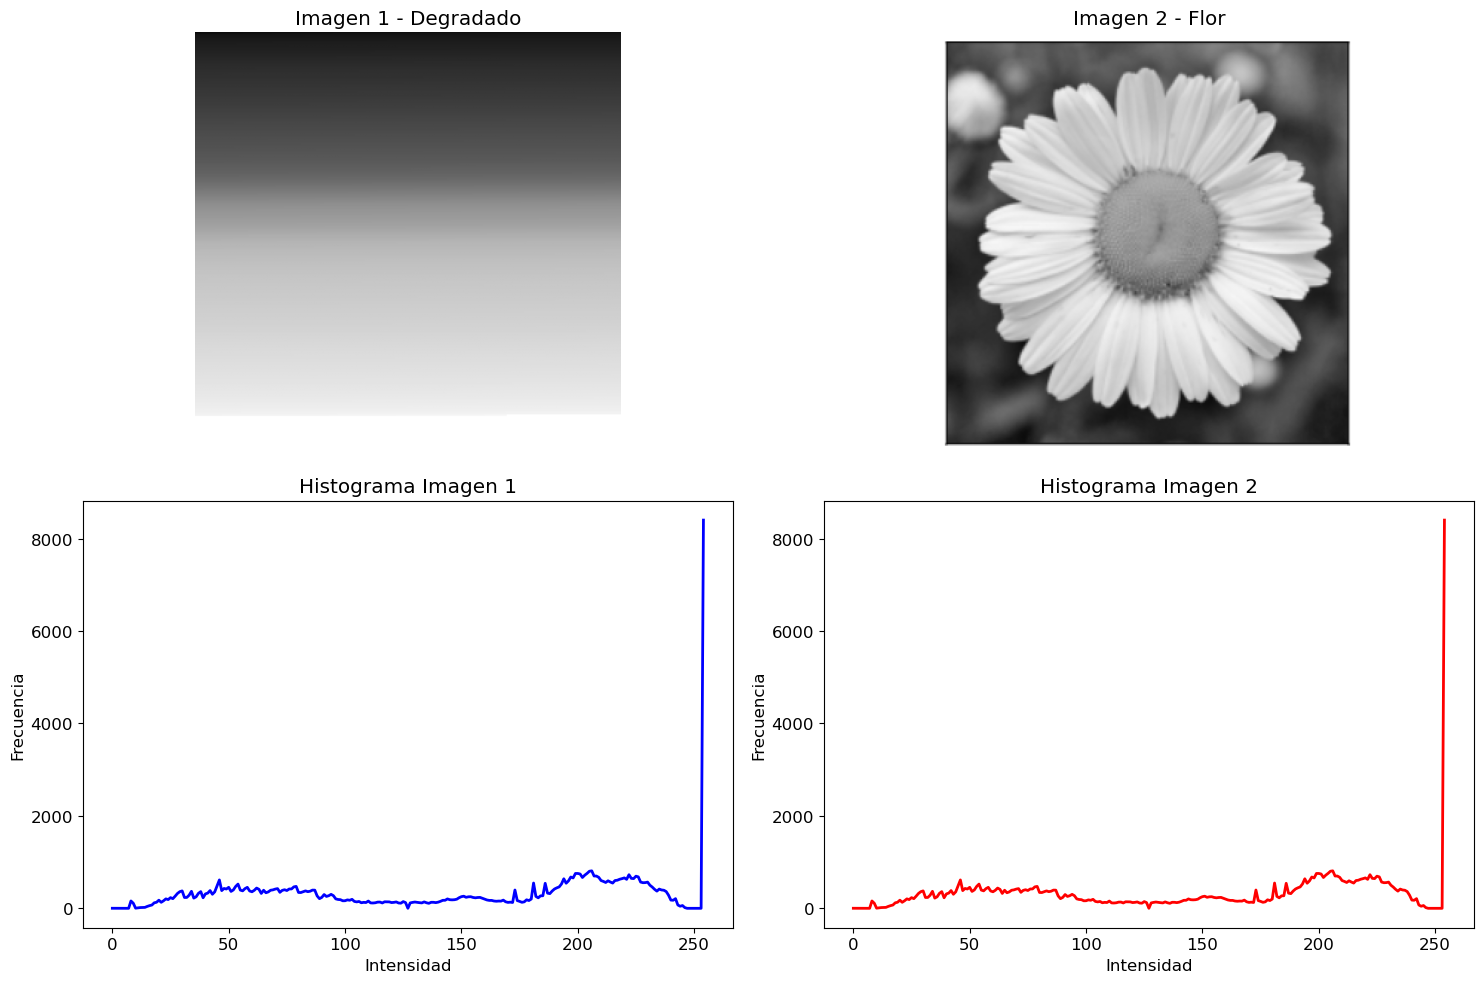

<Figure size 1200x800 with 0 Axes>

In [10]:
fig_1 = plt.figure(figsize=(15, 10))

ax1 = plt.subplot(2, 2, 1)
ax1.imshow(img_1, cmap='gray', vmin=0, vmax=255)
ax1.set_title("Imagen 1 - Degradado")
ax1.axis('off')

ax2 = plt.subplot(2, 2, 2)
ax2.imshow(img_2, cmap='gray', vmin=0, vmax=255)
ax2.set_title("Imagen 2 - Flor")
ax2.axis('off')

ax3 = plt.subplot(2, 2, 3)
ax3.plot(hist_1, color='blue', linewidth=2)
ax3.set_title("Histograma Imagen 1")
ax3.set_xlabel("Intensidad")
ax3.set_ylabel("Frecuencia")

ax4 = plt.subplot(2, 2, 4)
ax4.plot(hist_2, color='red', linewidth=2)
ax4.set_title("Histograma Imagen 2")
ax4.set_xlabel("Intensidad")
ax4.set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()
plt.savefig("results/histogramas.png", dpi=300, bbox_inches='tight')

### Análisis estadístico

Respecto a si conviene emplear histogramas como características para clasificar imágenes, la respuesta es que es posible utilizarlos, pero hay que considerar que en un histograma se descarta toda la información espacial. Es decir, pueden existir dos imágenes con idéntico histograma y contenidos totalmente distintos.

No lo recomendaría para tareas de clasificación de imágenes, ya que existen enfoques que preservan mejor la estructura espacial, como la convolución con filtros. Estos permiten capturar patrones locales y detalles relevantes, fundamentales para clasificar.

Este es un contrajemplo contundente: el histograma de una imagen no la representa de forma unívoca. Usarlo como feature en un algoritmo de clasificación/detección puede ser válido, pero requiere verificación cuidadosa, porque pueden darse casos en los que dos imágenes completamente diferentes compartan el mismo histograma o uno muy similar.

In [11]:
print("Imagen 1 (Degradado):")
print(f"Media: {np.mean(img_1):.2f}")
print(f"Desviación estándar: {np.std(img_1):.2f}")
print(f"Min: {np.min(img_1)}, Max: {np.max(img_1)}")

print("\nImagen 2 (Flor):")
print(f"Media: {np.mean(img_2):.2f}")
print(f"Desviación estándar: {np.std(img_2):.2f}")
print(f"Min: {np.min(img_2)}, Max: {np.max(img_2)}")

differences = np.abs(hist_1 - hist_2)
total_diff = np.sum(differences)

print(f"\nDiferencia total en histogramas: {total_diff}")
print(f"Histogramas idénticos: {'Sí' if total_diff == 0 else 'No'}")

Imagen 1 (Degradado):
Media: 154.81
Desviación estándar: 75.34
Min: 2, Max: 255

Imagen 2 (Flor):
Media: 154.81
Desviación estándar: 75.34
Min: 2, Max: 255

Diferencia total en histogramas: 0
Histogramas idénticos: Sí
